In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
fdata = sc.read_h5ad('./RNA/reclustered.h5')

In [3]:
sc.pp.highly_variable_genes(fdata, n_top_genes=10000, flavor='seurat_v3', inplace=True)
hvg_data = fdata[:, fdata.var['highly_variable']].copy()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [4]:
from sklearn.decomposition import NMF
cnt_matrix = hvg_data.X.toarray()
model = NMF(n_components=100, verbose=1, max_iter=2000, random_state=114514)
cnt_matrix_trans = model.fit_transform(cnt_matrix)

import pickle
pickle.dump(model, open('./nmf_model.hvg.100.pkl', 'wb'))

violation: 1.0
violation: 0.02209320880980071
violation: 0.02232471799187128
violation: 0.025805842240337065
violation: 0.02481740230475032
violation: 0.024439149076565487
violation: 0.02498205764796635
violation: 0.02473781243743287
violation: 0.024114433981000005
violation: 0.023556421583632102
violation: 0.023163362391632955
violation: 0.022917230577972812
violation: 0.022772445710968085
violation: 0.02273697273851732
violation: 0.02265950038797858
violation: 0.022648484445046937
violation: 0.022623310032107154
violation: 0.022593943770076688
violation: 0.022547978496295744
violation: 0.022462290765116313
violation: 0.022350708906249423
violation: 0.02220521991916314
violation: 0.022005307642018256
violation: 0.021780827030733918
violation: 0.021519293717822706
violation: 0.021213083619609992
violation: 0.020864437633364402
violation: 0.020490740223615734
violation: 0.020063659241557806
violation: 0.019636541504639376
violation: 0.01921953303234155
violation: 0.018801156137567655
vi

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 2000 reached. Increase it to improve convergence.
  warnings.warn(


In [5]:
np.save('./nmf_matrix.hvg.100.npy', cnt_matrix_trans)

In [16]:
cnt_matrix_trans = np.load('./nmf_matrix.hvg.100.npy')
import pickle
model = pickle.load(open('./nmf_model.hvg.100.pkl', 'rb'))

In [6]:
from scipy.stats import pearsonr
from tqdm import tqdm

corr_matrix = np.zeros((cnt_matrix_trans.shape[1], cnt_matrix_trans.shape[1]))
for i in tqdm(range(cnt_matrix_trans.shape[1])):
    for j in range(i, cnt_matrix_trans.shape[1]):
        corr_matrix[i, j] = pearsonr(cnt_matrix_trans[:, i], cnt_matrix_trans[:, j])[0]

100%|██████████| 100/100 [00:07<00:00, 13.33it/s]


In [7]:
for i in tqdm(range(corr_matrix.shape[1])):
    for j in range(i):
        corr_matrix[i, j] = corr_matrix[j, i]

np.save('./nmf_corr_matrix.hvg.100.npy', corr_matrix)

100%|██████████| 100/100 [00:00<00:00, 11249.61it/s]


In [17]:
corr_matrix = np.load('./nmf_corr_matrix.hvg.100.npy')

In [30]:
import consensusclustering as cc
from sklearn.cluster import AgglomerativeClustering

cc_model = cc.ConsensusClustering(
    AgglomerativeClustering(),
    min_clusters=4,
    max_clusters=20,
    n_resamples=100,
    resample_frac=0.8,
    k_param='n_clusters'
)
cc_model.fit(corr_matrix)
cc_model.best_k()

8

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


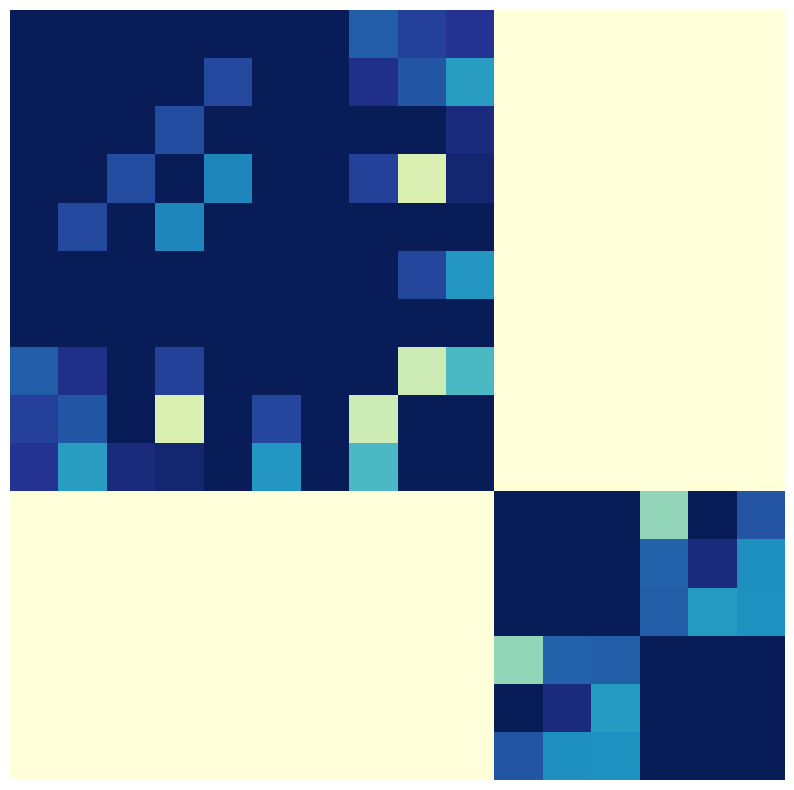

In [39]:

heatmap = cc_model.plot_clustermap(k=9)
reordered_idx = heatmap.dendrogram_row.reordered_ind
plt.close()

# plt.figure(figsize=(10, 10))
# sns.heatmap(corr_matrix[reordered_idx, :][:, reordered_idx], cmap='YlGnBu', vmin=0, vmax=0.2,
#             xticklabels=False, yticklabels=False, cbar=False)
# plt.show()

plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix[np.r_[reordered_idx[56:66], reordered_idx[85:91]], :][:, np.r_[reordered_idx[56:66], reordered_idx[85:91]]], cmap='YlGnBu', vmin=0, vmax=0.3,
            xticklabels=False, yticklabels=False, cbar=False)
plt.show()

In [57]:
cnt_matrix_trans[fdata.obs.marker == 'A', np.r_[reordered_idx[55:66]]].shape

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (4835,) (11,) 

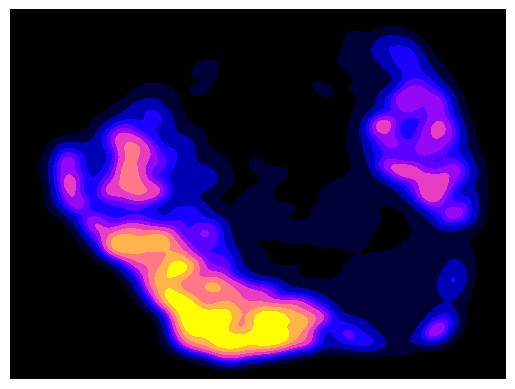

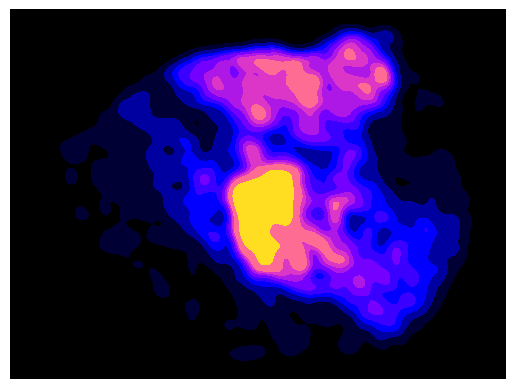

In [44]:
# sns.scatterplot(x=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 0], y=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 1],
#                 c=cnt_matrix_trans[fdata.obs.marker == 'A', :][:, np.r_[reordered_idx[55:66]]].sum(axis=1), s=15)
sns.kdeplot(x=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 0], y=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 1],
            weights=cnt_matrix_trans[fdata.obs.marker == 'A', :][:, np.r_[reordered_idx[56:66]]].sum(axis=1),
            cmap='gnuplot2', cbar=False, fill=True, bw_adjust=0.3)
sns.despine(left=True, bottom=True)
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.savefig('./plots/nmf_program_1.png', format='png', dpi=600)
plt.show()

# sns.scatterplot(x=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 0], y=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 1],
#                 c=cnt_matrix_trans[fdata.obs.marker == 'A', :][:, np.r_[reordered_idx[85:91]]].sum(axis=1), s=15)
sns.kdeplot(x=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 0], y=fdata[fdata.obs.marker == 'A'].obsm['spatial'][:, 1],
            weights=cnt_matrix_trans[fdata.obs.marker == 'A', :][:, np.r_[reordered_idx[85:91]]].sum(axis=1),
            cmap='gnuplot2', cbar=False, fill=True, bw_adjust=0.3)
sns.despine(left=True, bottom=True)
plt.gca().set_facecolor('black')
plt.xticks([])
plt.yticks([])
plt.savefig('./plots/nmf_program_2.png', format='png', dpi=600)
plt.show()

In [73]:
n_top = 20
gene_idx = np.argsort(model.components_, axis=1)[:, -n_top:].flatten()
df = pd.DataFrame(columns=['Gene', 'Cluster'])
for idx, i in enumerate([[55, 66], [85, 91]]):
    df = pd.concat([df, pd.DataFrame({
        'Gene': np.unique(hvg_data.var_names[gene_idx[i[0]*n_top:(i[1]+1)*n_top]]),
        'Cluster': idx
    })])
df.to_csv('~/stereoseq/20240502-SPACseq/DEG.csv', index=False, sep='\t')
df

,Gene,Cluster
0,AW112010,0
1,AY036118,0
2,Acaca,0
3,Acadvl,0
4,Acsl5,0
...,...,...
131,Usp34,1
132,Wars,1
133,Ybx1,1
134,Ywhah,1


In [74]:
!sshpass -p wang2024 ssh wpy@172.16.10.103 "mamba run -n gsea python ~/stereoseq/20240502-SPACseq/enrich.py"

Gene       object
Cluster     int64
dtype: object
/home/wpy/stereoseq/20240502-SPACseq/bin/go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms
Enrichment analysis for list 0 completed successfully: 2418
Enrichment analysis for list 1 completed successfully: 2367



In [76]:
for i in range(2):
    enr = pd.read_csv(f"~/stereoseq/20240502-SPACseq/GO/Cluster_{i}.result", sep="\t")
    results = enr.sort_values(by='Combined Score', ascending=False)
    results = results[results["Adjusted P-value"] < 0.05]
    results = results.loc[:, ["Term", "Genes", "Adjusted P-value"]]
    results["Cluster"] = i
    results["Gene Counts"] = results["Genes"].str.split(";").apply(len)
    results["Term"] = results["Term"].str.split("R-HSA").str[0]
    results["Term"] = results["Term"].str.split("\(").str[0]
    results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value', ascending=True)).reset_index(drop=True)
    if not i: go_df = results
    else: go_df = pd.concat([go_df, results], axis=0)
# go_df.to_csv('./GO/Reactome.csv', index=None, sep='\t')
go_df

<>:9: SyntaxWarning: invalid escape sequence '\('
<>:9: SyntaxWarning: invalid escape sequence '\('
/tmp/ipykernel_188221/471641421.py:9: SyntaxWarning: invalid escape sequence '\('
  results["Term"] = results["Term"].str.split("\(").str[0]
/tmp/ipykernel_188221/471641421.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = results.groupby("Cluster", as_index=False).apply(lambda x: x.sort_values(by='Adjusted P-value', ascending=True)).reset_index(drop=True)
/tmp/ipykernel_188221/471641421.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operati

,Term,Genes,Adjusted P-value,Cluster,Gene Counts
0,Alzheimer disease,COX8A;NDUFB8;COX8B;NDUFA11;LRP1;NDUFA5;NDUFB2;...,1.582948e-07,0,15
1,Non-alcoholic fatty liver disease,COX8A;NDUFB8;COX8B;NDUFA11;NDUFA5;ADIPOQ;NDUFB...,1.043987e-06,0,13
2,Oxidative phosphorylation,COX8A;NDUFB8;COX8B;NDUFA11;NDUFA5;NDUFAB1;NDUF...,1.672392e-06,0,12
3,Parkinson disease,COX8A;NDUFB8;COX8B;NDUFA11;NDUFA5;NDUFAB1;NDUF...,2.806712e-06,0,12
4,Citric Acid,COX8A;NDUFB8;NDUFA11;NDUFA5;NDUFB2;ETFB;SDHB;C...,1.433408e-05,0,13
...,...,...,...,...,...
327,NOTCH3 Intracellular Domain Regulates Transcri...,STAT1;RBPJ,4.914254e-02,1,2
328,TRAF6 Mediated NF-kB Activation,NFKBIA;HMGB1,4.914254e-02,1,2
329,Signaling By ERBB2 In Cancer,NRAS;GRB2,4.914254e-02,1,2
330,Parkinson disease,COX8A;NDUFA8;NDUFA1;SDHD,4.937574e-02,1,4


In [94]:
go_df[go_df["Cluster"] == 0].iloc[30:50, :]
# go_df[go_df["Cluster"] == 1].iloc[50:100, :]

,Term,Genes,Adjusted P-value,Cluster,Gene Counts
30,Renin-angiotensin system,CPA3;CMA1;MCPT4;LNPEP,0.011023,0,4
31,HIF-1 signaling pathway,EGLN2;STAT3;ELOC;ENO3;HIF1A;MAPK3,0.015850,0,6
32,Response To Hydrogen Peroxide,ANXA1;HP;CLU;AQP1;NFE2L2,0.017959,0,5
33,Retrograde endocannabinoid signaling,NDUFB8;NDUFA11;NDUFA5;NDUFAB1;NDUFB2;NDUFV3;MAPK3,0.019497,0,7
34,Cardiac muscle contraction,COX8A;COX8B;TPM2;UQCRC2;COX7A1,0.022768,0,5
35,Actomyosin Structure Organization,PDLIM1;ITGB5;EPB41L2;TNNT3;TCAP;TTN,0.022913,0,6
36,Regulation Of Transcription From RNA Polymeras...,BAG3;HIF1A;NFE2L2,0.023576,0,3
37,mRNA Stabilization,SYNCRIP;MAPKAPK2;YBX1;HNRNPC;TARDBP,0.023576,0,5
38,Mitochondrial Respiratory Chain Complex I Asse...,NDUFB8;NDUFA11;NDUFA5;NDUFAB1;NDUFB2,0.023576,0,5
39,Regulation Of Striated Muscle Contraction,GRK2;TNNT3;SRI;CALM2,0.023576,0,4


/tmp/ipykernel_188221/3332945286.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_188221/3332945286.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


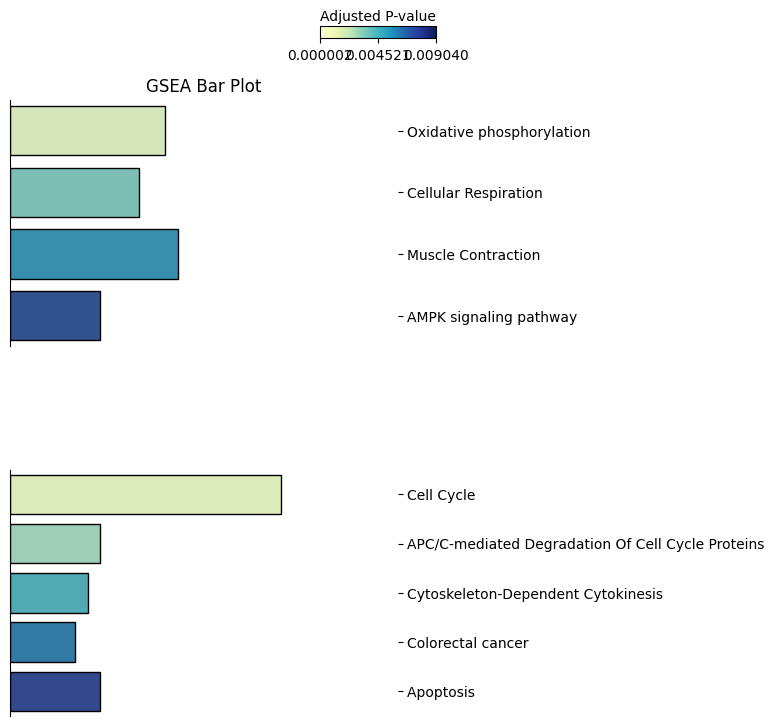

In [99]:
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(2, 1, figsize=(5, 8))
for cluster in range(2):
    if cluster == 0:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[2, 6, 7, 27], :]
    elif cluster == 1:
        gsea_results = go_df[go_df["Cluster"] == cluster].iloc[[1, 18, 55, 66, 70], :]

    barplot = sns.barplot(
        x='Gene Counts', 
        y='Term', 
        data=gsea_results, 
        palette="YlGnBu",
        edgecolor='black',
        ax=ax[cluster]
    )
    # for tick in ax[cluster].get_xticks():
        # ax[cluster].axvline(x=tick, linestyle='--', color='gray', alpha=0.5)

    norm = plt.Normalize(gsea_results['Adjusted P-value'].min(), gsea_results['Adjusted P-value'].max())
    sm = plt.cm.ScalarMappable(cmap="YlGnBu", norm=norm)
    sm.set_array([])
    if cluster == 0:
        cax = inset_axes(ax[cluster], width="30%", height="5%", loc='upper right',
                         bbox_to_anchor=(0.1, 0.3, 1, 1), bbox_transform=ax[cluster].transAxes, borderpad=0)

        cbar = fig.colorbar(sm, cax=cax, label="Adjusted P-value", orientation='horizontal', shrink=0.1)
        cbar.ax.xaxis.set_label_position('top')
    # else: cbar = fig.colorbar(sm, cax=cax, orientation='horizontal', shrink=0.1)

        cbar_ticks = np.linspace(gsea_results['Adjusted P-value'].min(), gsea_results['Adjusted P-value'].max(), num=3)  # Adjust num for density
        cbar.set_ticks(cbar_ticks)
        cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    # ax[cluster].set_xscale('log')
    ax[cluster].yaxis.tick_right()
    ax[cluster].set_ylabel('')

    ax[cluster].set_xlabel('')
    # ax[cluster].set_ylabel(f'Cluster {cluster}')
    ax[cluster].set_xlim(0, 30)

    if cluster != 5:
        ax[cluster].set_xticks([])
        sns.despine(ax=ax[cluster], left=False, bottom=True)
    else:
        sns.despine(ax=ax[cluster], left=False, bottom=False)


plt.subplots_adjust(hspace=0.5)
ax[0].set_title('GSEA Bar Plot')
# ax[5].set_xlabel('Enriched Gene Counts')

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/nmf_program_gsea.pdf', dpi=300, format='pdf')
plt.show()